# AWS NetCDF Data Tests

**Goal**
<br/>
To use the MUR 1-km dataset stored in an S3 bucket within Amazon Web Services (AWS) in conjunction with the MUR Climatology dataset (created by Mike Chin and cleaned in the notebook 'CleaningMURClimatologyData.ipynb') to create a Sea Surface Temperature (SST) anomaly dataset for use in testing runtimes on dataset loading and plotting applications. 

**Run Location**
<br/>
This notebook was run on an AWS EC2 t3.medium instance. It was discovered that for this specific analysis and dataset a t3.small instance did not provide enough memory.

**Dataset**
<br/>
MUR 1-km L4 SST netCDF4 AWS (requires AWS early access in order to view on Earthdata Search) https://podaac.jpl.nasa.gov/MEaSUREs-MUR?tab=background&sections=about%2Bdata

### Import Modules

In [28]:
%matplotlib inline
import s3fs
import numpy as np
import xarray as xr
import fsspec
import zarr
import timeit
import matplotlib.pyplot as plt
import requests
import netCDF4
from dask.distributed import Client, performance_report
from json import dumps
from io import StringIO
from os.path import dirname, join
from IPython.display import HTML

In [29]:
ShortName = "MUR-JPL-L4-GLOB-v4.1"

### Earthdata Login
<br/>
You should have a .netrc file in your home directory set up like:

    machine urs.earthdata.nasa.gov 
    login <username> 
    password <password>

### Direct Access to Data from S3

In [30]:
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

s3fs.core.S3FileSystem

## Setup for Regional Tests

### Period and Region of Interest

In [31]:
start_date = "2019-08-01"
end_date = "2020-1-20"

minlat = 18
maxlat = 23
minlon = -160
maxlon = -154

### Open MUR Dataset

In [32]:
start_time = timeit.default_timer()


mur_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, "*2019*.nc"))
mur_files = mur_files[212:]

mur_files2020 = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, "*202001*.nc"))
mur_files2020 = mur_files2020[:20]

for day in mur_files2020:
    mur_files.append(day)

variables=[
    'analysed_sst', 
    'mask'
]

def subset(ds):
    subset_ds = ds[variables].sel(
        lat=slice(minlat, maxlat),
        lon=slice(minlon, maxlon)
    )
    return subset_ds

mur_hawaii = xr.open_mfdataset(
    paths=[fs.open(f) for f in mur_files],
    preprocess=subset,
    combine='by_coords',
    engine='h5netcdf'
).chunk({"time": 30, "lat": 100, "lon": 100})

mur_hawaii.load()   # Uncomment if you want to load the dataset into memory now


elapsed = timeit.default_timer() - start_time
print(elapsed)

224.708464542


In [33]:
mur_hawaii

<xarray.Dataset>
Dimensions:       (time: 173, lat: 501, lon: 601)
Coordinates:
  * time          (time) datetime64[ns] 2019-08-01T09:00:00 ... 2020-01-20T09...
  * lat           (lat) float32 18.0 18.01 18.02 18.03 ... 22.98 22.99 23.0
  * lon           (lon) float32 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0
Data variables:
    analysed_sst  (time, lat, lon) float32 301.0 301.0 301.0 ... 296.8 296.8
    mask          (time, lat, lon) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

### Add in NAN Values for Land to MUR Data
<br/>
We use the mask dimension to replace temperature values from land observations with NaN so that they are not factored in to our calculations. The mask variable has a value for each coordinate pair representing which surface the temperature was collected from (land, open-sea, ice, etc.).

In [34]:
mur_hawaii_sst = mur_hawaii['analysed_sst'].where(mur_hawaii.mask == 1)

### Convert Temperatures to Celsius
<br/>
The dataset is stored with temperatures measured in Kelvin. This converts it to Celsius for ease of understanding and analysis.

In [35]:
mur_hawaii_sst = mur_hawaii_sst - 273.15

In [36]:
mur_hawaii_sst

<xarray.DataArray 'analysed_sst' (time: 173, lat: 501, lon: 601)>
array([[[27.894012, 27.888   , 27.876007, ..., 26.64801 , 26.630005,
         26.618988],
        [27.87799 , 27.876007, 27.871002, ..., 26.622986, 26.604004,
         26.592987],
        [27.854004, 27.859985, 27.863007, ..., 26.59201 , 26.571014,
         26.561005],
        ...,
        [27.102997, 27.109985, 27.128998, ..., 26.764008, 26.751007,
         26.743988],
        [27.101013, 27.114014, 27.13501 , ..., 26.751007, 26.742004,
         26.735992],
        [27.089996, 27.109985, 27.136993, ..., 26.738007, 26.731995,
         26.727997]],

       [[27.710999, 27.716003, 27.679993, ..., 26.929993, 26.931   ,
         26.93399 ],
        [27.632996, 27.639008, 27.617004, ..., 26.932007, 26.932007,
         26.934998],
        [27.556   , 27.561005, 27.549988, ..., 26.933014, 26.933014,
         26.936005],
...
        [24.507996, 24.519989, 24.53299 , ..., 23.662994, 23.694   ,
         23.72699 ],
        [24.509003, 24.522003, 24.536987, ..., 23.635986, 23.669006,
         23.70401 ],
        [24.511993, 24.526001, 24.540985, ..., 23.610992, 23.647003,
         23.683014]],

       [[25.52301 , 25.536987, 25.56601 , ..., 25.031006, 25.013   ,
         25.011993],
        [25.556   , 25.55899 , 25.571991, ..., 25.04599 , 25.036987,
         25.033997],
        [25.582   , 25.574005, 25.571014, ..., 25.058014, 25.057007,
         25.050995],
        ...,
        [24.389008, 24.394012, 24.403992, ..., 23.682007, 23.723999,
         23.778992],
        [24.394012, 24.394989, 24.401001, ..., 23.632996, 23.68399 ,
         23.743988],
        [24.39801 , 24.39801 , 24.401001, ..., 23.574005, 23.631989,
         23.696991]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2019-08-01T09:00:00 ... 2020-01-20T09:00:00
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 22.97 22.98 22.99 23.0
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0

### Open MUR Climatology for Hawaii

In [37]:
mur_clim = xr.open_dataarray(
    "../data/MURClimatology.nc", 
    chunks={"time": 30, "lat": 100, "lon": 100}
)

In [38]:
mur_clim

,Array,Chunk
Bytes,420.39 MiB,1.14 MiB
Shape,"(366, 501, 601)","(30, 100, 100)"
Count,547 Tasks,546 Chunks
Type,float32,numpy.ndarray


### Drop the Leap Day

In [39]:
mur_clim = mur_clim.where(mur_clim["time"] != np.datetime64('2004-02-29T09:00:00', 'ns'), drop=True)

### Create Subset Dataset

In [40]:
mur_clim_jan = mur_clim[0:20]

In [41]:
mur_clim_subset = mur_clim[212:]

In [42]:
mur_clim_subset = xr.concat([mur_clim_subset, mur_clim_jan], dim="time")

In [43]:
mur_clim_subset = mur_clim_subset.assign_coords({"time": mur_hawaii_sst["time"]})

In [44]:
mur_clim_subset

<xarray.DataArray 'sstclim' (time: 173, lat: 501, lon: 601)>
dask.array<concatenate, shape=(173, 501, 601), dtype=float32, chunksize=(30, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 22.97 22.98 22.99 23.0
  * time     (time) datetime64[ns] 2019-08-01T09:00:00 ... 2020-01-20T09:00:00
Attributes:
    description:  Hawaii Climatology from 2002-2015.
    start_date:   01/01
    end_date:     12/31
    units:        degC

### Create SST Anomaly Dataset

In [45]:
sst_anomaly = mur_hawaii_sst - mur_clim_subset

In [46]:
sst_anomaly

<xarray.DataArray (time: 173, lat: 501, lon: 601)>
dask.array<subtract, shape=(173, 501, 601), dtype=float32, chunksize=(30, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-08-01T09:00:00 ... 2020-01-20T09:00:00
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 22.97 22.98 22.99 23.0
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0

### Find Daily Average SST Anomaly for Time Series

In [47]:
sst_anomaly_mean_ts = sst_anomaly.mean(['lat', 'lon'])

In [48]:
sst_anomaly_mean_ts

<xarray.DataArray (time: 173)>
dask.array<mean_agg-aggregate, shape=(173,), dtype=float32, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-08-01T09:00:00 ... 2020-01-20T09:00:00

### Find Average SST Anomaly for Each Coordinate Pair for Spatial Plot

In [49]:
sst_anomaly_mean_sp = sst_anomaly.mean(['time'])

In [50]:
sst_anomaly_mean_sp

<xarray.DataArray (lat: 501, lon: 601)>
dask.array<mean_agg-aggregate, shape=(501, 601), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 22.97 22.98 22.99 23.0
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0

## Regional Tests

### Regional SST Anomaly Averaged Time Series, August 1st, 2019 - January 20th, 2020
<br/>
Kernel dies on t3.small, likely due to limited memory (RAM)

0.9168034159999934


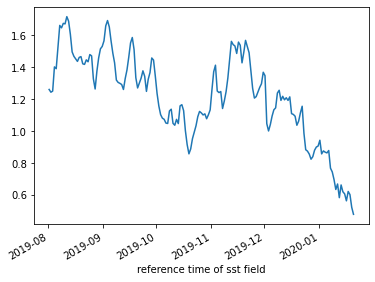

In [51]:
start_time = timeit.default_timer()

sst_anomaly_mean_ts.plot()

elapsed = timeit.default_timer() - start_time
print(elapsed)

### Regional SST Anomaly Averaged Spatial Plot, August 1st, 2019 - January 20th, 2020
<br/>
Kernel dies on t3.small, likely due to limited memory (RAM)

/home/ec2-user/miniconda3/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.9889538529998845


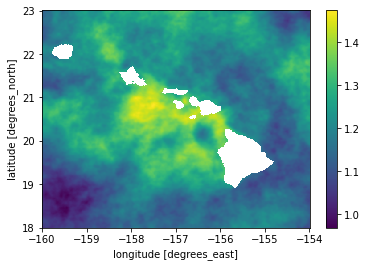

In [52]:
start_time = timeit.default_timer()

sst_anomaly_mean_sp.plot()

elapsed = timeit.default_timer() - start_time
print(elapsed)